In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from functools import partial

%matplotlib inline
plt.style.use("ggplot")

jax.config.update("jax_enable_x64", True)

In [8]:
%load_ext autoreload
%autoreload 1
%aimport solver.hydro
%aimport solver.solvers
%aimport solver.limiters
%aimport solver.muscl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def imshow(f, size=10, axis=None):
    plt.figure(figsize=(size, size))
    if axis is None:
        extent = None
    else:
        extent = [axis.min(), axis.max(), axis.min(), axis.max()]

    plt.imshow(f, origin="lower", extent=extent)
    plt.colorbar()


def title(e0=1e5, d0=1.0, C=0.5, n=128):
    plt.title("e0={:.0e}   d0={:.0e}   C={:.1f}  n={}".format(e0, d0, C, n))

# Kelvin-Helmholtz

In [10]:
def kelvin_helmholtz_initial_conditions(
    n, L, a=0.05, sigma=0.2, u_flow=1, P0=10, A=0.01
):
    """
    Initialize the conditions for a Kelvin-Helmholtz instability.

    Parameters:
    nx, ny: Grid points in x and y directions
    Lx, Ly: Dimensions of the domain in x and y directions
    rho1, rho2: Densities of the two fluids
    v1, v2: Velocities of the two fluids
    delta: Thickness of the transition layer between the two fluids

    Returns:
    rho: Density field
    vx: Velocity field in x direction
    vy: Velocity field in y direction (initially zero)
    """
    # Create coordinate arrays
    x = jnp.linspace(0, L, n)
    y = jnp.linspace(0, 2 * L, 2 * n)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    y1 = 0.5 * L
    y2 = 1.5 * L

    jump = 0  # delta rho / rho0

    rho = 1 + jump * 0.5 * (jnp.tanh((Y - y1) / a) - jnp.tanh((Y - y2) / a))
    ux = u_flow * (jnp.tanh((Y - y1) / a) - jnp.tanh((Y - y2) / a) - 1)
    uy = (
        A
        * jnp.sin(2 * jnp.pi * X)
        * (jnp.exp(-(((Y - y1) / sigma) ** 2)) + jnp.exp(-(((Y - y2) / sigma) ** 2)))
    )
    c = 0.5 * (jnp.tanh((Y - y2)) - jnp.tanh((Y - y1)) + 2)

    return rho, x, y, ux, uy, c

In [11]:
def create_state(n=1024, L=1.0, gamma=5 / 3, dtype=jnp.float32):
    ds = L / n

    P = jnp.ones((n, 2 * n)) * 10
    rho, x, y, vx, vy, c = kelvin_helmholtz_initial_conditions(n, L)

    total_energy = P / (gamma - 1) + 0.5 * rho * (vx**2 + vy**2)
    state = solver.hydro.HydroState(
        n=n,
        ds=ds,
        dx=ds,
        dy=ds,
        x=dtype(x),
        y=dtype(y),
        density=dtype(rho),
        dye_concentration=dtype(c),
        total_energy=dtype(total_energy),
        momentum_x=dtype(vx * rho),
        momentum_y=dtype(vy * rho),
        adiabatic_index=gamma,
    )

    return state


state = create_state()

In [13]:
state = solver.hydro.load_state("kh_2048-01.pkl")

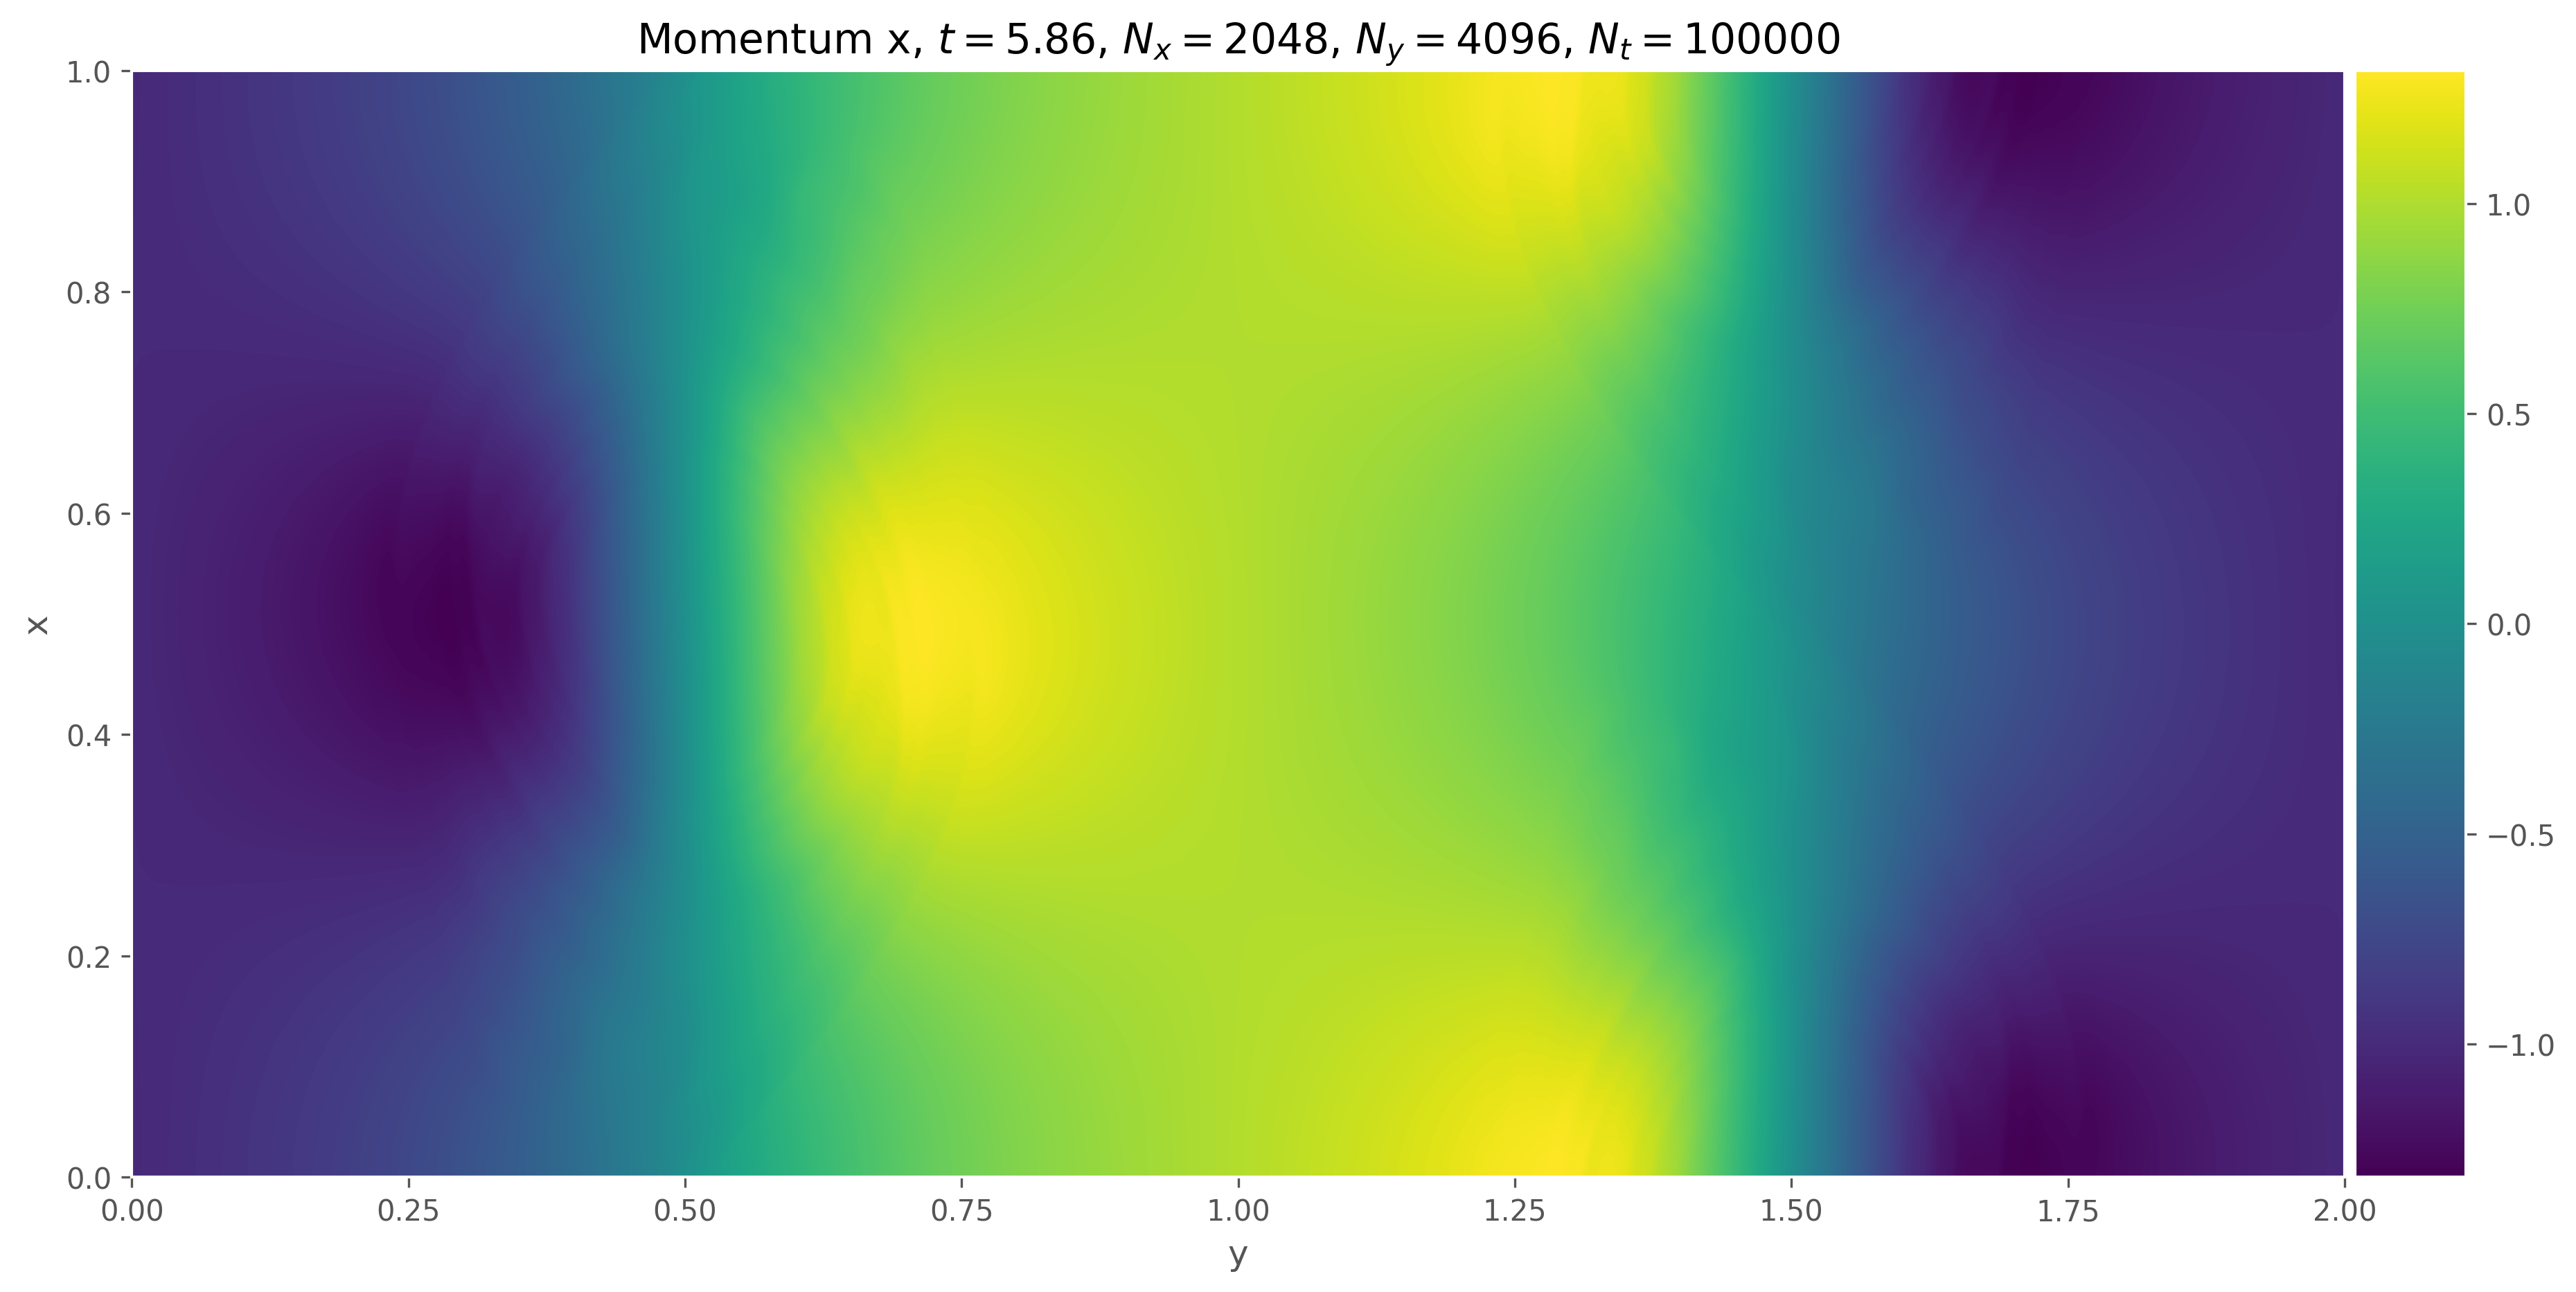

In [19]:
show_state(state, "momentum_x")

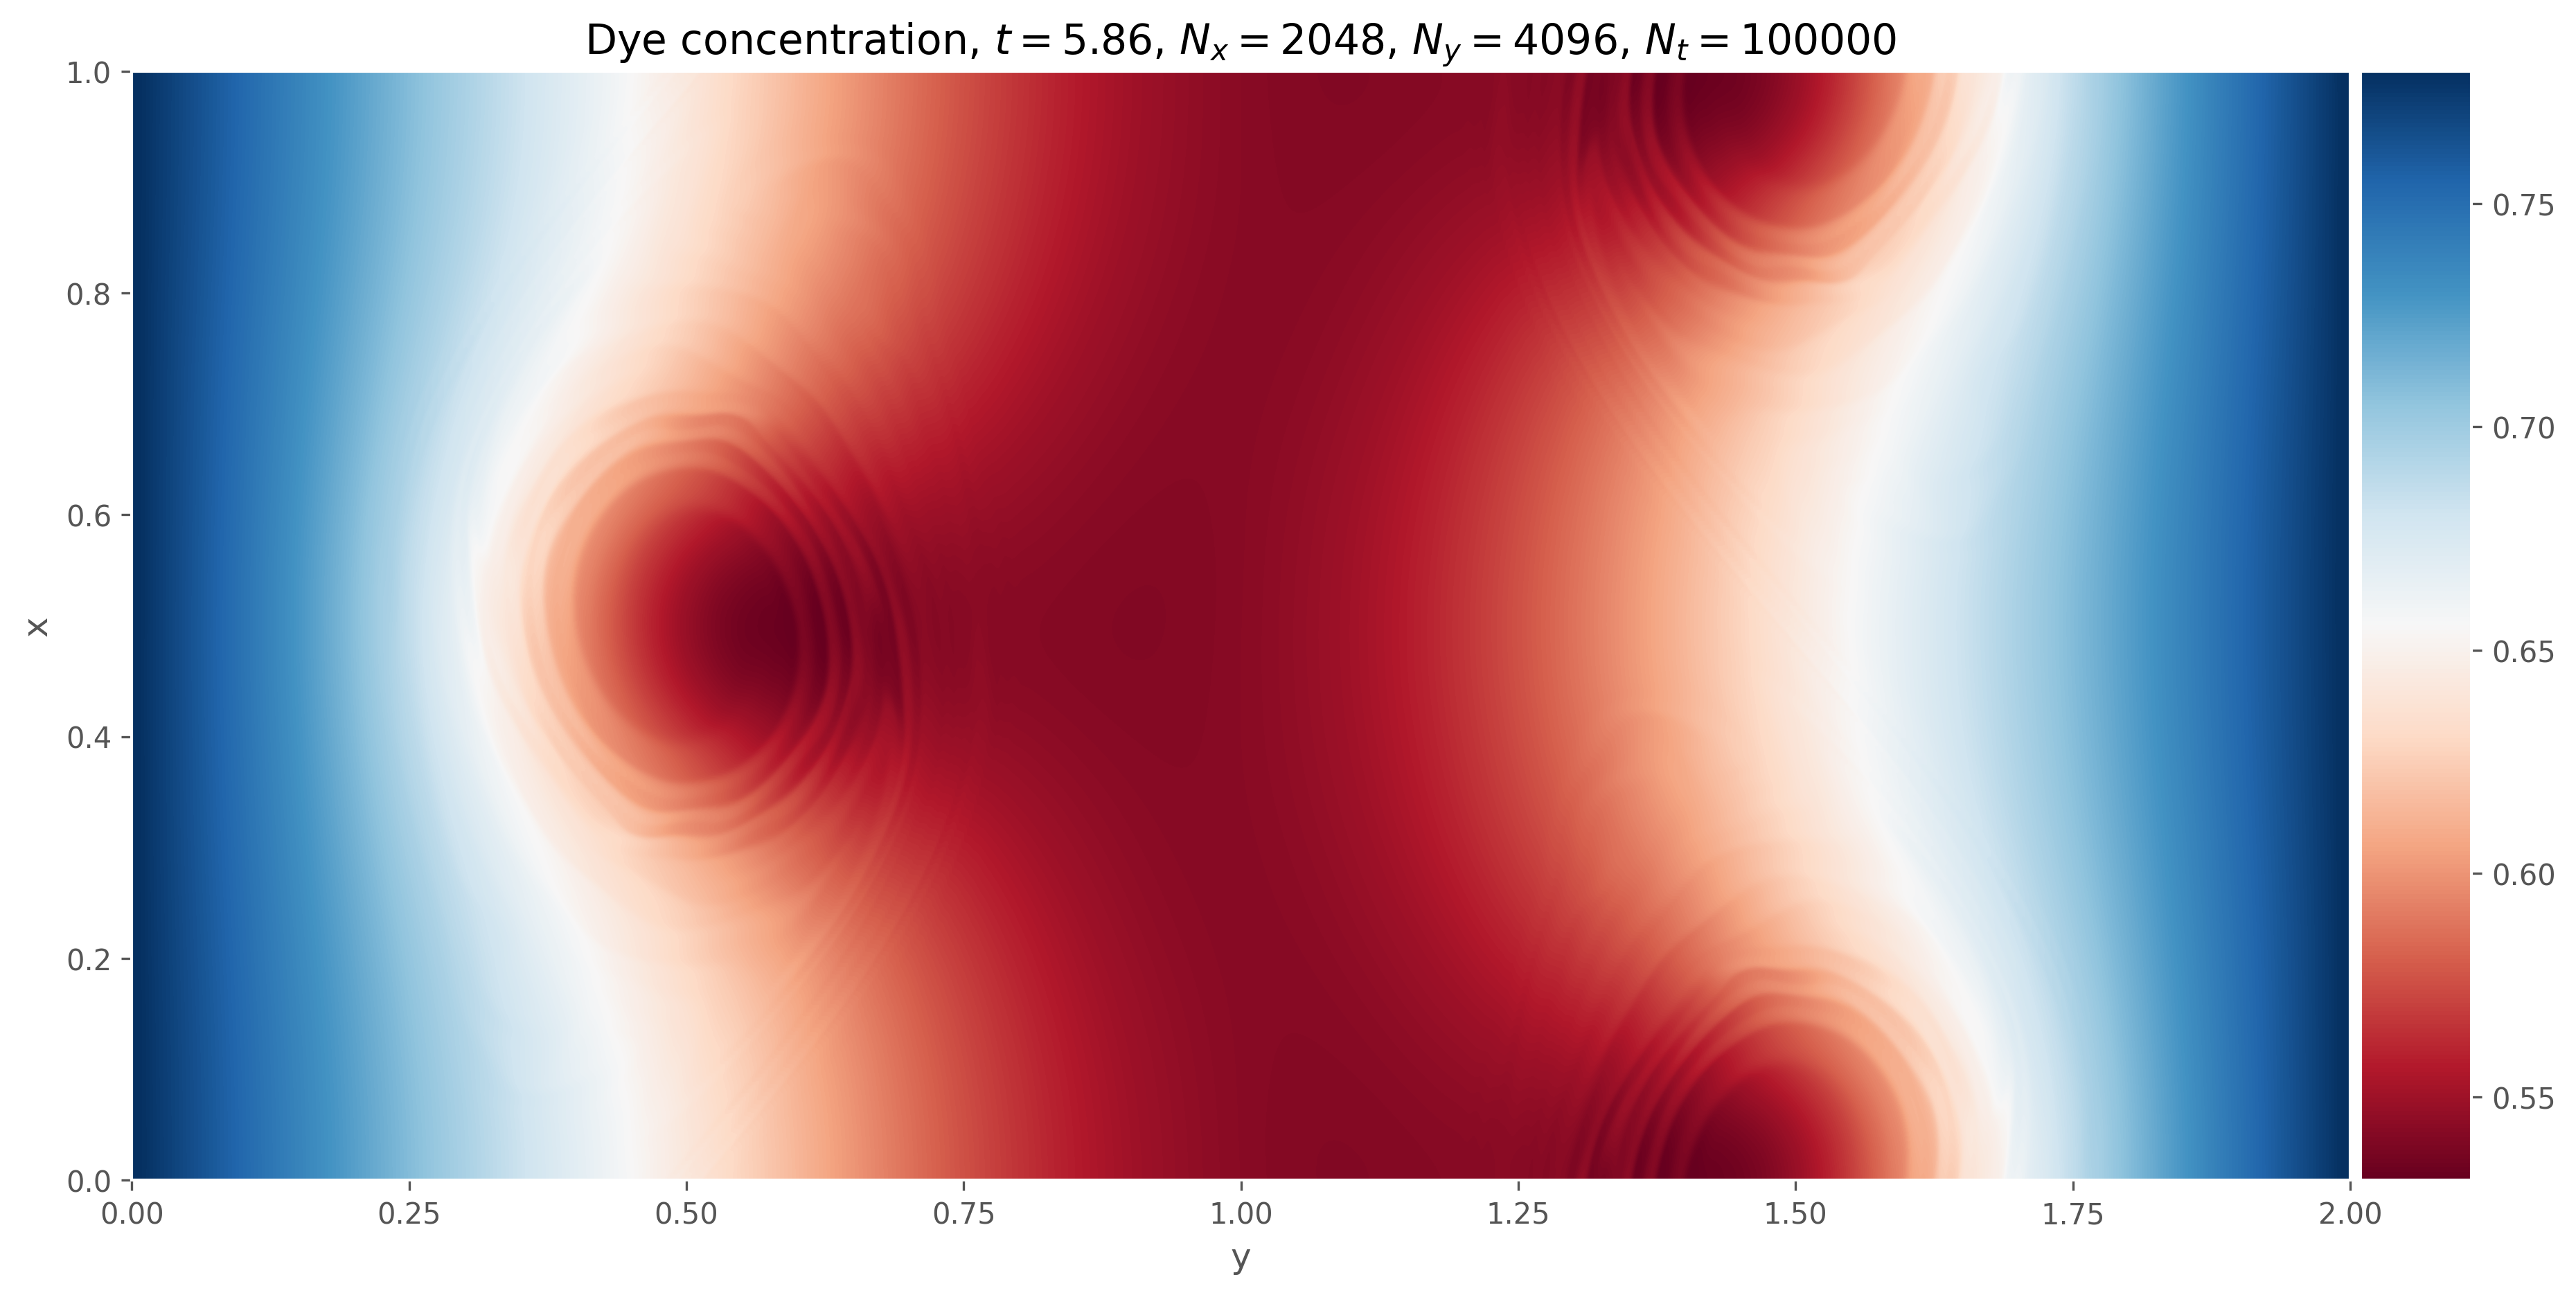

In [17]:
def show_state(state, varname="dye_concentration", cmap="viridis"):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    extent = [state.y.min(), state.y.max(), state.x.min(), state.x.max()]
    labelname = varname.replace("_", " ").capitalize()
    nx = state.x.size
    ny = state.y.size
    aspect_ratio = nx / ny
    title = f"{labelname}, $t={state.t:.2f}$, $N_x={nx}$, $N_y={ny}$, $N_t={state.it}$"

    fig, ax = plt.subplots(dpi=300)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.set_size_inches(25 * aspect_ratio, 25 / aspect_ratio)
    im = ax.imshow(getattr(state, varname), origin="lower", extent=extent, cmap=cmap)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.set_title(title)
    ax.grid(False)

    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()
    

show_state(state, cmap="RdBu")
plt.savefig("kh_2048-density.pdf", bbox_inches="tight")

In [17]:
from tqdm import trange

def run_kelvin_helmholtz(n=1024, nt=100, C=0.5, dtype=jnp.float32):
    jax.config.update("jax_debug_nans", False)

    riemann_solver = solver.solvers.local_lax_friedrichs
    slope_limiter = solver.limiters.monotonized_central
    state = create_state(n=n, dtype=dtype)
    start = time()

    with trange(int(nt), desc="MUSCL 2D") as pbar:
        for i in pbar:
            pbar.set_postfix({"t": f"{state.t:.3f}"})
            state = solver.muscl.muscl_2d(
                state,
                C,
                slope_limiter=slope_limiter,
                riemann_solver=riemann_solver,
                enable_dye=True,
            )

    used = time() - start

    print(
        "total: {:.1f} sec, {:.2f} microseconds/update".format(
            used, 1e6 * used / (n**2 * nt)
        )
    )

    return state


state = run_kelvin_helmholtz(n=4096, nt=200000, C=0.5)
solver.hydro.save_state(state, "kh_4096-200k-f32.pkl.xz")
show_state(state, "density")

MUSCL 2D:  14%|█▎        | 27095/200000 [17:06<1:49:50, 26.24it/s, time=0.847]

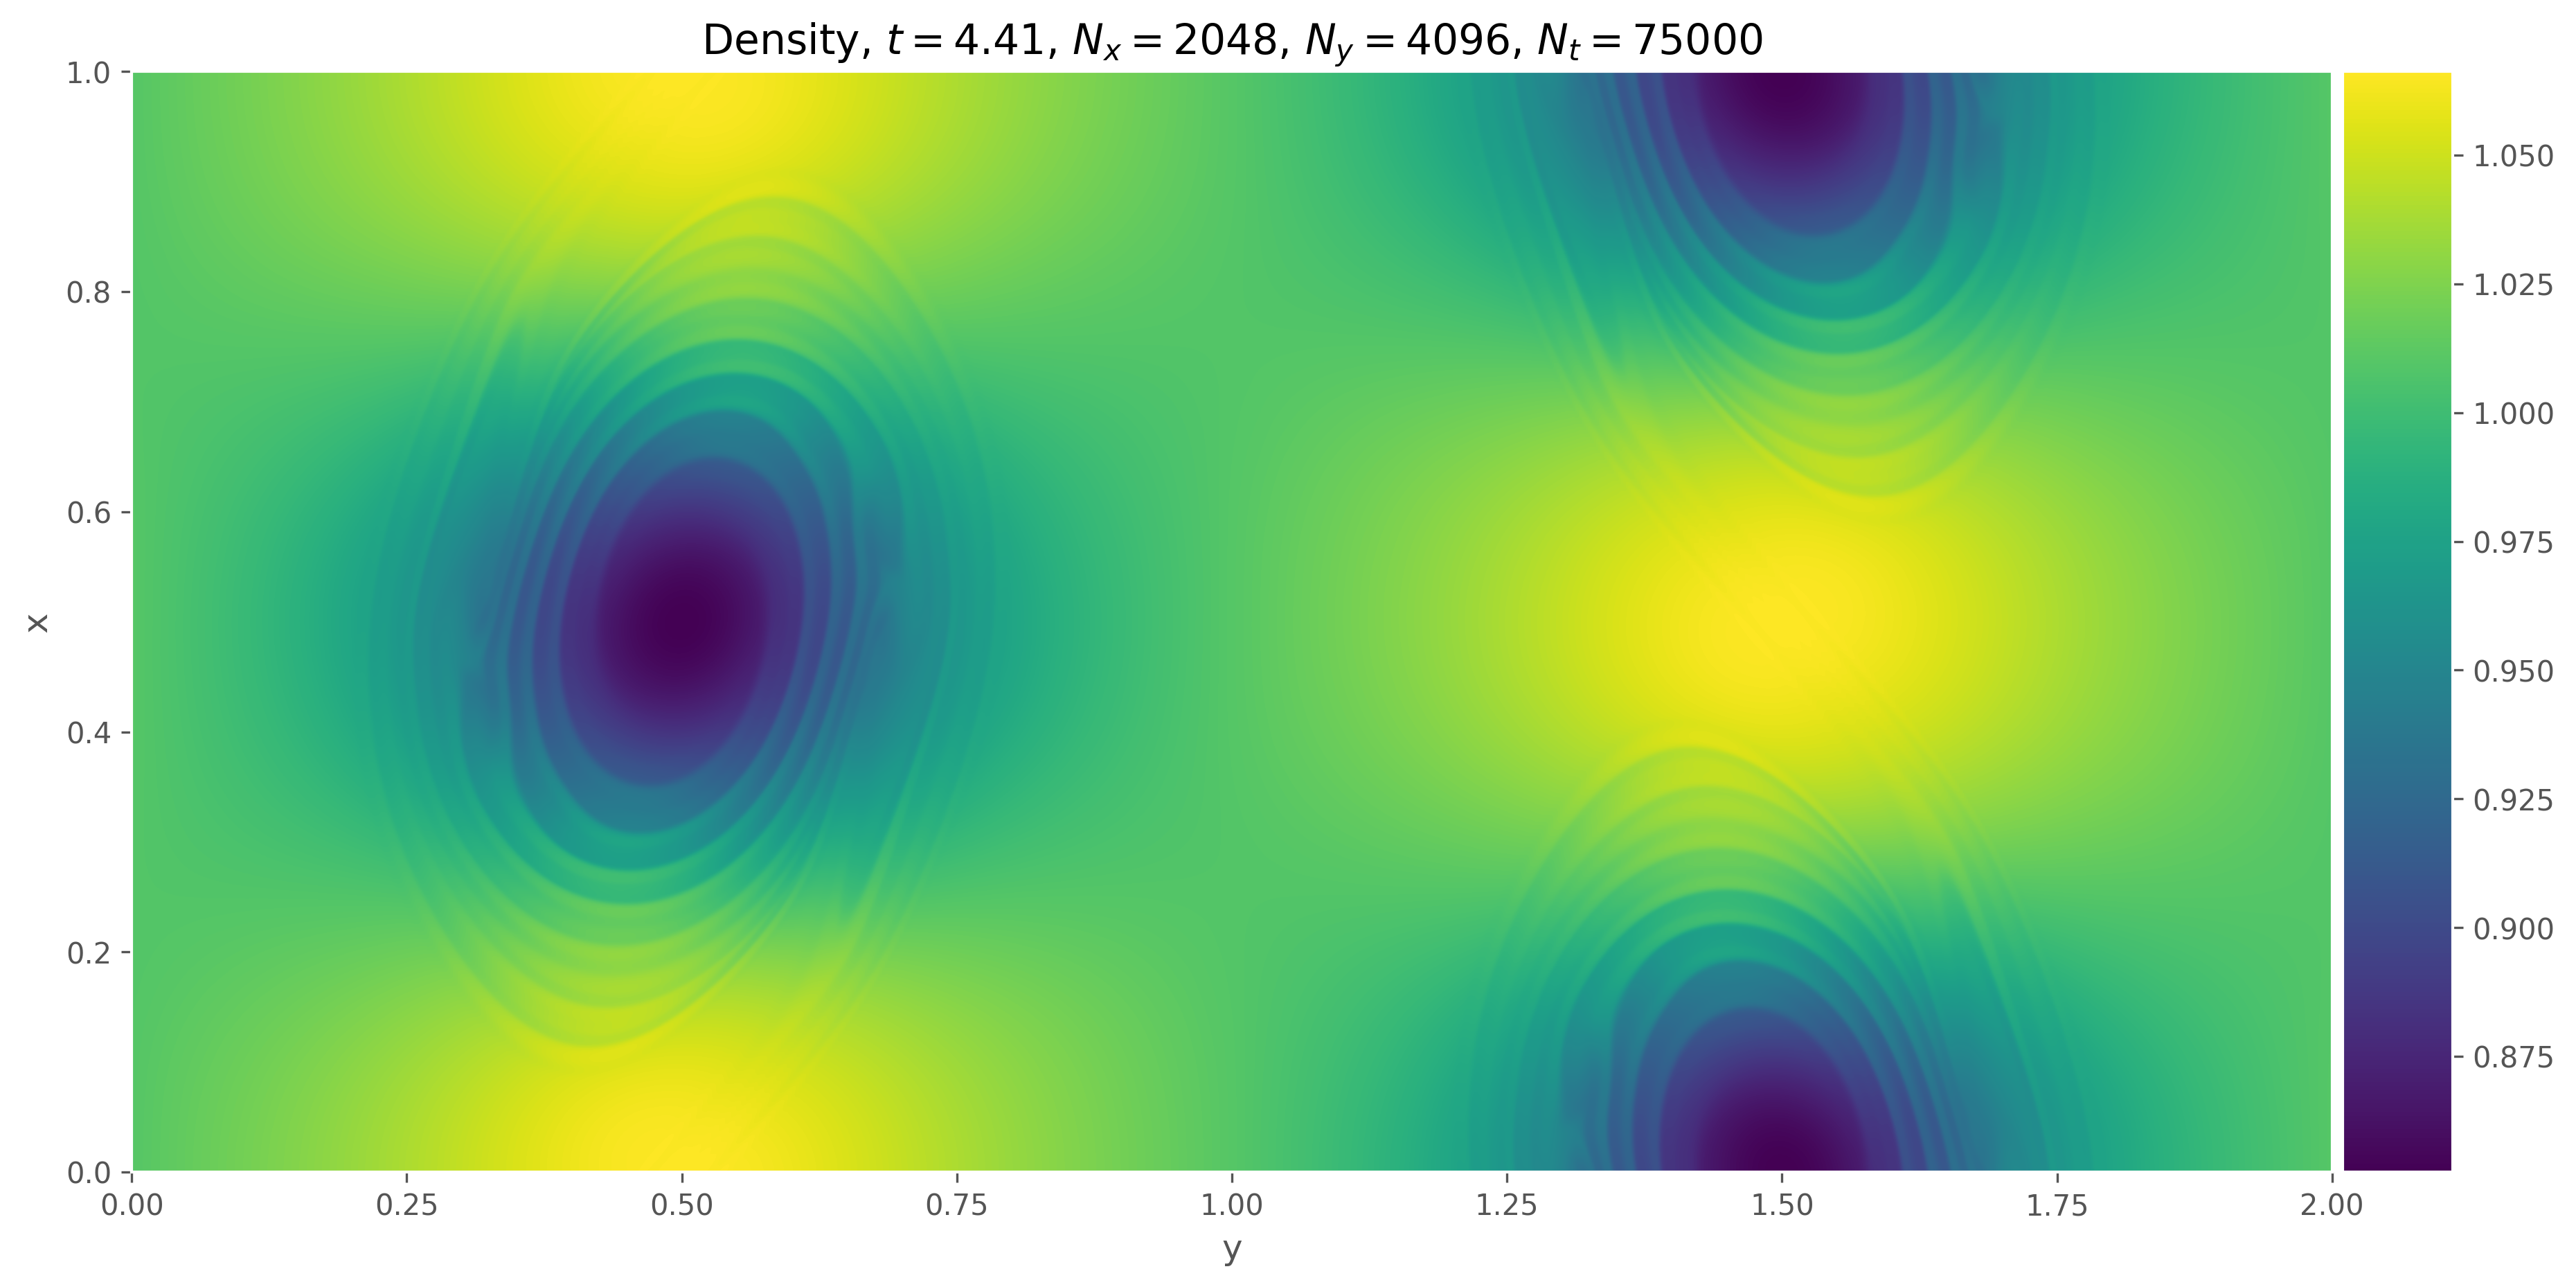

In [ ]:
# solver.hydro.save_state(state, "kh_2048.pkl")
show_state(state, "density")
plt.savefig("kh_density.pdf")

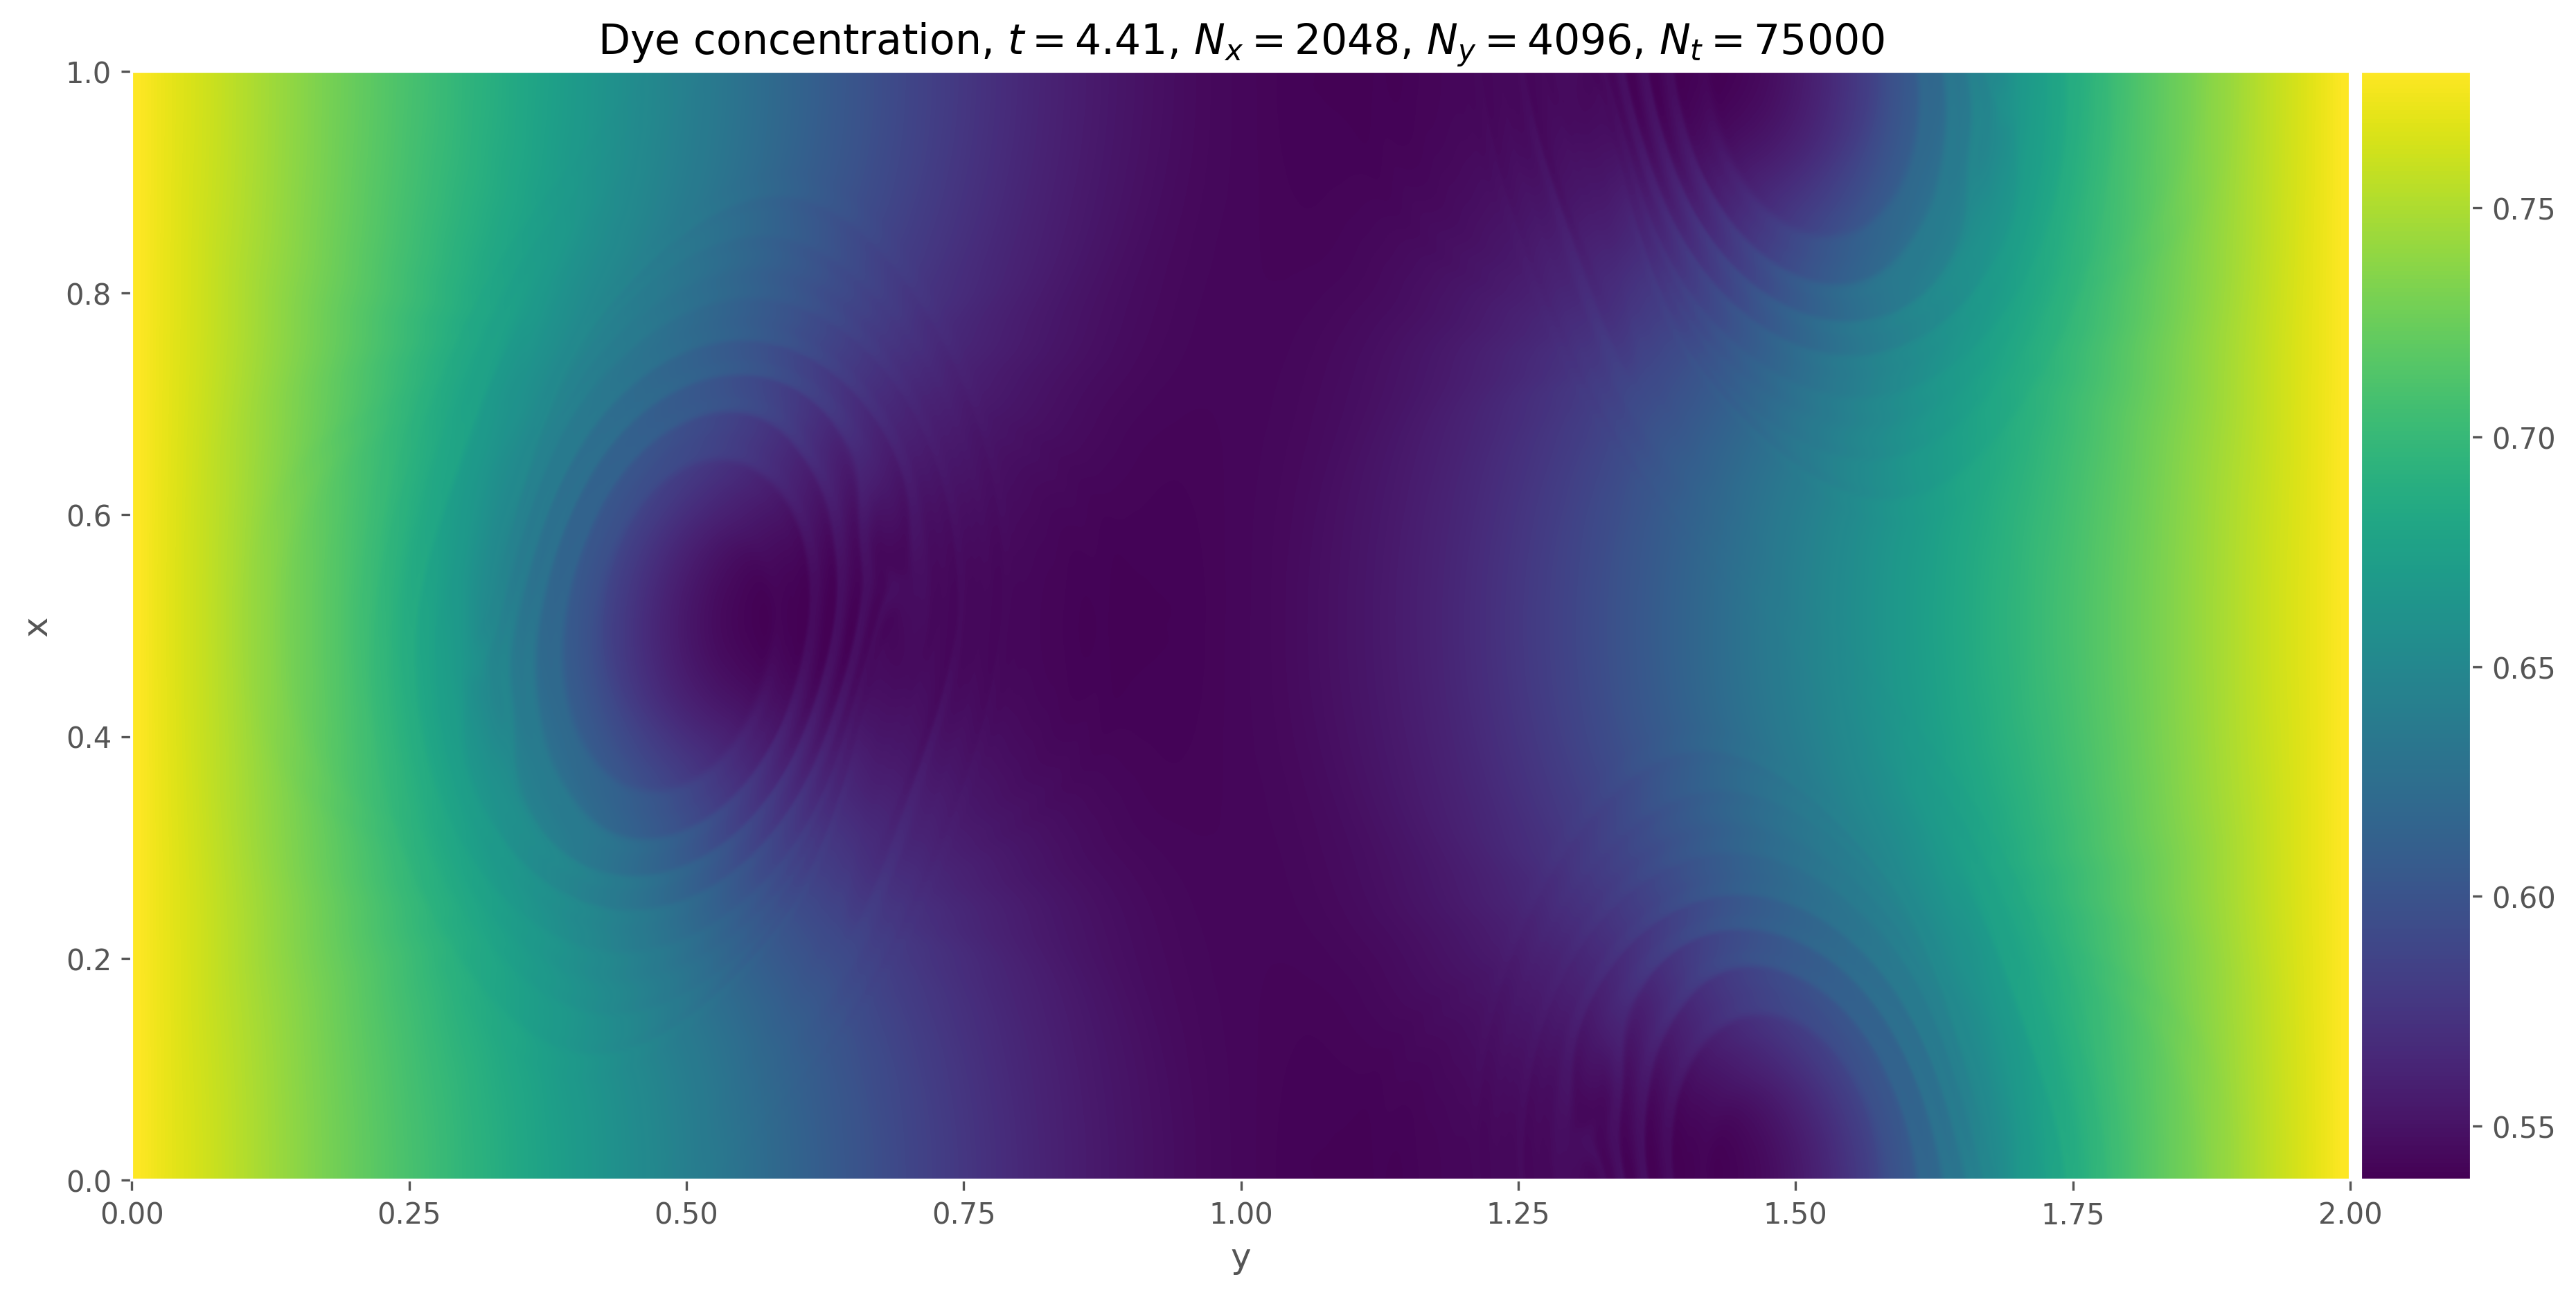

In [ ]:
show_state(state, "dye_concentration")

In [ ]:
sol

Array(0.00030584, dtype=float32)